<a href="https://colab.research.google.com/github/0o999oo/oe/blob/master/spytorch/SpyTorchTutorial1_AND2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

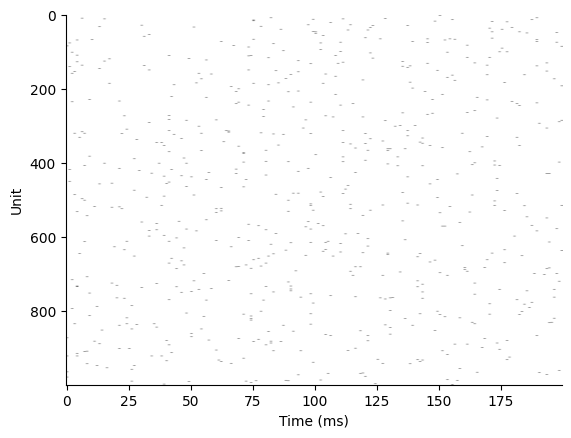

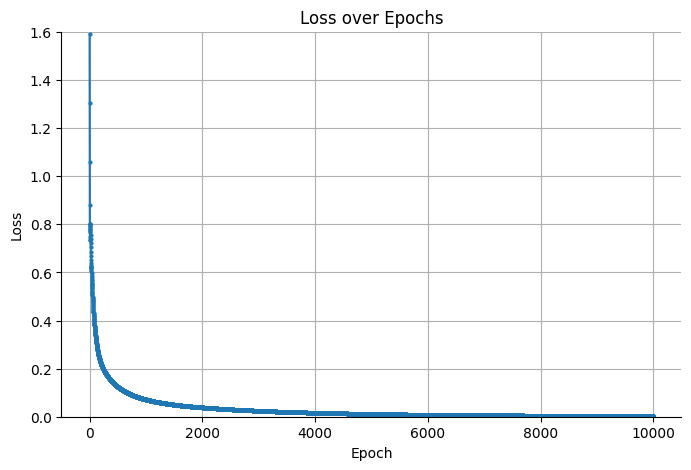

Accuracy 0.999
Test Accuracy: 0.949
Frequency 3 Hz Accuracy: 0.973
Frequency 10 Hz Accuracy: 0.977
Frequency 50 Hz Accuracy: 0.898


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

torch.manual_seed(0)

dtype = torch.float
device = torch.device("cpu")

def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

# freq の設定
freq_values = [3, 10, 50]
batch_size = 256  # バッチサイズをここで設定

# 入力データ生成
time_step = 1e-3
nb_inputs = 1000
nb_hidden = 100
nb_outputs = 2
nb_steps = 200

# 各周波数に対応するラベルと入力データを生成
x_data = []
y_data = []

for f in freq_values:
    prob = f * time_step
    mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype)
    x_data_freq = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
    x_data_freq[mask < prob] = 1.0
    label = 1 if f == 50 else 0  # freq=3ならラベル0、それ以外は1
    y_data_freq = torch.tensor([label] * batch_size, device=device)

    x_data.append(x_data_freq)
    y_data.append(y_data_freq)

# 入力データとラベルを結合してバッチにまとめる
x_data = torch.cat(x_data, dim=0)  # (3 * batch_size, nb_steps, nb_inputs)
y_data = torch.cat(y_data, dim=0)  # (3 * batch_size, )

# 入力データの一部を可視化
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

# モデルの初期化
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step / tau_syn))
beta = float(np.exp(-time_step / tau_mem))

weight_scale = 7 * (1.0 - beta)  # 初期スパイクを作るためのスケール設定

w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale / np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale / np.sqrt(nb_hidden))

# SNNの前方計算関数を定義
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((inputs.size(0), nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((inputs.size(0), nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # 隠れ層の活動を計算
    for t in range(nb_steps):
        mthr = mem - 1.0
        out = spike_fn(mthr)
        rst = out.detach()  # リセット時にバックプロパゲーションを防ぐ

        new_syn = alpha * syn + h1[:, t]
        new_mem = (beta * mem + syn) * (1.0 - rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)

    # 出力層の計算
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((inputs.size(0), nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((inputs.size(0), nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha * flt + h2[:, t]
        new_out = beta * out + flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec, dim=1)
    return out_rec, [mem_rec, spk_rec]

# 学習関数
def train_snn():
    params = [w1, w2]
    optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))  # Adamオプティマイザー

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    for e in range(10000):
        output, _ = run_snn(x_data)
        m, _ = torch.max(output, 1)
        log_p_y = log_softmax_fn(m)
        loss_val = loss_fn(log_p_y, y_data)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        loss_hist.append(loss_val.item())

    return loss_hist

loss_hist = train_snn()

# 損失の推移をプロット
plt.figure(figsize=(8, 5))
plt.plot(loss_hist, marker='o', markersize=2, linestyle='-')
plt.ylim(0, max(loss_hist) + 0.01)  # y軸を自動調整
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.grid(True)
sns.despine()
plt.show()

# 最終的な精度の確認
def print_classification_accuracy():
    output, _ = run_snn(x_data)
    m, _ = torch.max(output, 1)
    _, am = torch.max(m, 1)
    acc = np.mean((y_data == am).detach().cpu().numpy())  # ラベルと比較
    print("Accuracy %.3f" % acc)

print_classification_accuracy()


# 推論用データの生成
def generate_test_data():
    test_x_data = []
    test_y_data = []
    for f in freq_values:
        prob = f * time_step
        mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype)
        x_data_freq = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
        x_data_freq[mask < prob] = 1.0
        label = 1 if f == 50 else 0  # freq=3ならラベル0、それ以外は1
        y_data_freq = torch.tensor([label] * batch_size, device=device)

        test_x_data.append(x_data_freq)
        test_y_data.append(y_data_freq)

    # テストデータを結合してバッチにまとめる
    test_x_data = torch.cat(test_x_data, dim=0)  # (3 * batch_size, nb_steps, nb_inputs)
    test_y_data = torch.cat(test_y_data, dim=0)  # (3 * batch_size, )
    return test_x_data, test_y_data

# 推論の実行と精度の評価
def evaluate_snn():
    test_x_data, test_y_data = generate_test_data()
    output, _ = run_snn(test_x_data)
    m, _ = torch.max(output, 1)
    _, predicted_labels = torch.max(m, 1)

    # 正解ラベルと予測ラベルを比較して精度を計算
    accuracy = np.mean((test_y_data == predicted_labels).detach().cpu().numpy())
    print("Test Accuracy: %.3f" % accuracy)

    # 各周波数ごとの分類結果を表示
    for i, f in enumerate(freq_values):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        acc_per_freq = np.mean((test_y_data[start_idx:end_idx] == predicted_labels[start_idx:end_idx]).detach().cpu().numpy())
        print(f"Frequency {f} Hz Accuracy: {acc_per_freq:.3f}")

# 推論の実行
evaluate_snn()